In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# Define Dataset

In [2]:
from torch.utils.data import Dataset, DataLoader

class RNA2D_Dataset(Dataset):
    def __init__(self,data):
        self.data=data
        self.tokens={nt:i for i,nt in enumerate('ACGU')}

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence=[self.tokens[nt] for nt in self.data.loc[idx,'sequence']]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)

        return {'sequence':sequence}

In [3]:
archiveII_data = pd.read_csv("/kaggle/input/fixed-dataset-with-updated-dbn/archiveII_dataset_fixed.csv")
archiveII_dataset = RNA2D_Dataset(archiveII_data)
archiveII_dataset[0]
archiveII_data['bp'] = archiveII_data['pairs']

In [4]:
len(archiveII_data)

645

# Define Model

In [5]:
! pip install einops

  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/44/5a/f0b9ad6c0a9017e62d4735daaeb11ba3b6c009d69a26141b258cd37b5588/einops-0.8.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00


In [6]:
import sys

sys.path.append("/kaggle/input/ribonanzanet2d-final")

from Network import *
import yaml

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        self.entries=entries

    def print(self):
        print(self.entries)

def load_config_from_yaml(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return Config(**config)

class finetuned_RibonanzaNet(RibonanzaNet):
    def __init__(self, config):
        config.dropout=0.3
        super(finetuned_RibonanzaNet, self).__init__(config)

        self.dropout=nn.Dropout(0.0)
        self.ct_predictor=nn.Linear(64,1)

    def forward(self,src):
        
        #with torch.no_grad():
        _, pairwise_features=self.get_embeddings(src, torch.ones_like(src).long().to(src.device))

        pairwise_features=pairwise_features+pairwise_features.permute(0,2,1,3) #symmetrize

        output=self.ct_predictor(self.dropout(pairwise_features)) #predict

        return output.squeeze(-1)

In [7]:
model=finetuned_RibonanzaNet(load_config_from_yaml("/kaggle/input/ribonanzanet2d-final/configs/pairwise.yaml"))

constructing 9 ConvTransformerEncoderLayers


In [8]:
model.load_state_dict(torch.load("/kaggle/input/ribonanzanet-weights/RibonanzaNet-SS.pt",map_location='cpu'))

<All keys matched successfully>

# Make predictions

In [9]:
from tqdm import tqdm

archiveII_preds=[]
model.eval()
for i in tqdm(range(len(archiveII_data))):
    example=archiveII_dataset[i]
    sequence=example['sequence'].unsqueeze(0)

    with torch.no_grad():
        archiveII_preds.append(model(sequence).sigmoid().cpu().numpy())


  0%|          | 0/645 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 645/645 [2:07:38<00:00, 11.87s/it]  


In [5]:
import pickle

# Path to save the file
save_path = '/kaggle/working/archiveII_preds.pkl'

# Save the list to a pickle file
with open(save_path, 'wb') as f:
    pickle.dump(archiveII_preds, f)

print(f"List saved to {save_path}")


NameError: name 'archiveII_preds' is not defined

In [6]:
import pickle

# Path to load the file
load_path = '/kaggle/input/archive-ii-preds-pkl/archiveII_preds.pkl'

# Load the list from the pickle file
with open(load_path, 'rb') as f:
    archiveII_preds = pickle.load(f)

print(f"List loaded from {load_path}")


List loaded from /kaggle/input/archive-ii-preds-pkl/archiveII_preds.pkl


If you want to reload preds later: 

import pickle

Path to load the file
load_path = '/kaggle/working/archiveII_preds.pkl'

Load the list from the pickle file
with open(load_path, 'rb') as f:
    archiveII_preds = pickle.load(f)

print(f"List loaded from {load_path}")


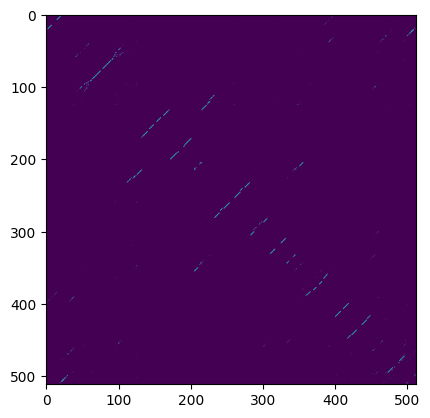

In [7]:
import matplotlib.pyplot as plt
plt.imshow(archiveII_preds[0][0])

In [8]:
#print(archiveII_preds[0][0][0]) 
print(len(archiveII_preds[0][0][0]))


512


# Discretize predicted probabilities into base pairs

We will be using the Hungarian algorithm implemented in Arnie (https://github.com/DasLab/arnie)

In [9]:
! pip install arnie

  Obtaining dependency information for arnie from https://files.pythonhosted.org/packages/d3/86/1a2d6dbc5f9409842b9ed4be84996a939a539f45598e18cd7de5141ebc52/arnie-0.1.9-py3-none-any.whl.metadata


In [10]:
import os

#create dummy arnie config
with open('arnie_file.txt','w+') as f:
    f.write("linearpartition: . \nTMP: /tmp")
    
os.environ['ARNIEFILE'] = 'arnie_file.txt'

from arnie.pk_predictors import _hungarian

def mask_diagonal(matrix, mask_value=0):
    matrix=matrix.copy()
    n = len(matrix)
    for i in range(n):
        for j in range(n):
            if abs(i - j) < 4:
                matrix[i][j] = mask_value
    return matrix


In [11]:
archiveII_preds_hungarian=[]
archiveII_hungarian_structures=[]
archiveII_hungarian_bps=[]
for i in range(len(archiveII_preds)):
    s,bp=_hungarian(mask_diagonal(archiveII_preds[i][0]),theta=0.5,min_len_helix=1) #best theta based on val is 0.5
    archiveII_hungarian_bps.append(bp)
    ct_matrix=np.zeros((len(s),len(s)))
    for b in bp:
        ct_matrix[b[0],b[1]]=1
    ct_matrix=ct_matrix+ct_matrix.T
    archiveII_preds_hungarian.append(ct_matrix)
    archiveII_hungarian_structures.append(s)
    #break




In [21]:
len(archiveII_hungarian_structures[0])





512

In [19]:
file = '/kaggle/input/fixed-dataset-with-updated-dbn/archiveII_dataset_fixed.csv'
df = pd.read_csv(file)
# Function to write ground truth and predicted DBNs to a file
def write_dbn_to_file(predicted_dbns, df, output_filename):
    with open(output_filename, 'w') as file:
        for i, predicted_dbn in enumerate(predicted_dbns):
            sequence_name = df.loc[i, 'sequence_name']
            sequence = df.loc[i, 'sequence']
            ground_truth_dbn = df.loc[i, 'dbn']
            
            # Write ground truth
            file.write(f">ground_truth_{sequence_name}\n")
            file.write(f"{sequence}\n")
            file.write(f"{ground_truth_dbn}\n")
            
            # Write predicted
            file.write(f">predicted_{sequence_name}\n")
            file.write(f"{sequence}\n")
            file.write(f"{predicted_dbn}\n")

# Example usage
# Assuming 'predicted_dbns' is your list of predicted DBN strings
# and 'df' is your DataFrame with the required columns
output_filename = 'archiveII_forna_input_file.txt'
write_dbn_to_file(archiveII_hungarian_structures, df, output_filename)

# Now, the file 'rna_dbn_output.txt' will contain the desired output.


# Calculate eF1 score

We found model confidence is linear correlated with F1 score, so we created linear regression models that estimate F1 scores based on confidence of predictions using our test dataset

In [12]:
def dedupe_lists(list_of_lists):
    # Step 1: Convert each sublist to a sorted tuple
    tuple_set = {tuple(sorted(sublist)) for sublist in list_of_lists}
    
    # Step 2: Convert the set of tuples back to a list of lists
    deduped_list = [list(tup) for tup in tuple_set]
    
    return deduped_list

def detect_crossed_pairs(bp_list):
    """
    Detect crossed base pairs in a list of base pairs in RNA secondary structure.

    Args:
    bp_list (list of tuples): List of base pairs, where each tuple (i, j) represents a base pair.
    
    Returns:
    list of tuples: List of crossed base pairs.
    """
    crossed_pairs_set = set()
    crossed_pairs = []
    # Iterate through each pair of base pairs
    for i in range(len(bp_list)):
        for j in range(i+1, len(bp_list)):
            bp1 = bp_list[i]
            bp2 = bp_list[j]

            # Check if they are crossed
            if (bp1[0] < bp2[0] < bp1[1] < bp2[1]) or (bp2[0] < bp1[0] < bp2[1] < bp1[1]):
                crossed_pairs.append(bp1)
                crossed_pairs.append(bp2)
                crossed_pairs_set.add(bp1[0])
                crossed_pairs_set.add(bp1[1])
                crossed_pairs_set.add(bp2[0])
                crossed_pairs_set.add(bp2[1])
    return dedupe_lists(crossed_pairs), crossed_pairs_set

In [16]:
eF1s=[]
for pred, bp_list in zip(archiveII_preds,archiveII_hungarian_bps):
    bpp=pred[0]
    
    crossed_pairs,crossed_pairs_set=detect_crossed_pairs(bp_list)
    global_confidence=np.mean([bpp[j, k] for j, k in bp_list])
    cross_pair_confidence=np.mean([bpp[j, k] for j, k in crossed_pairs])
    
#     global_ef1=3.66*global_confidence-2.7
#     crossed_pair_ef1=6.2*cross_pair_confidence-5.17
    
    global_ef1=2.21*global_confidence-1.25
    crossed_pair_ef1=2.02*cross_pair_confidence-1.27
    
    
    
    
    eF1s.append({'global_ef1':global_ef1,"crossed_pair_ef1":crossed_pair_ef1})
    
    
    
    

In [14]:
eF1s

[{'global_ef1': 0.783194504380226, 'crossed_pair_ef1': 0.39461581468582163},
 {'global_ef1': 0.9031215208768844, 'crossed_pair_ef1': nan},
 {'global_ef1': 0.830226313471794, 'crossed_pair_ef1': 0.47448816537857064},
 {'global_ef1': 0.7448592633008957, 'crossed_pair_ef1': 0.47726594567298886},
 {'global_ef1': 0.4785711938142776, 'crossed_pair_ef1': 0.2603498518466949},
 {'global_ef1': 0.7649708342552186, 'crossed_pair_ef1': 0.5244593143463134},
 {'global_ef1': 0.7050618606805801, 'crossed_pair_ef1': 0.5193476736545564},
 {'global_ef1': 0.7897899067401886, 'crossed_pair_ef1': 0.5865934109687805},
 {'global_ef1': 0.566034404039383, 'crossed_pair_ef1': 0.28481757998466484},
 {'global_ef1': 0.7491473484039306, 'crossed_pair_ef1': 0.512095296382904},
 {'global_ef1': 0.7502431792020796, 'crossed_pair_ef1': 0.42860259652137755},
 {'global_ef1': 0.7668049907684327, 'crossed_pair_ef1': 0.5218759822845458},
 {'global_ef1': 0.7644945120811464, 'crossed_pair_ef1': 0.15912010192871096},
 {'global_ef

# Calculate F1 scores againts ground truth 2D structures

In [19]:
def dotbrackte2bp(structure):
    stack={'(':[],
           '[':[],
           '<':[],
           '{':[]}
    pop={')':'(',
         ']':'[',
         '>':"<",
         '}':'{'}       
    bp_list=[]
    matrix=np.zeros((len(structure),len(structure)))
    for i,s in enumerate(structure):
        if s in stack:
            stack[s].append((i,s))
        elif s in pop:
            forward_bracket=stack[pop[s]].pop()
            #bp_list.append(str(forward_bracket[0])+'-'+str(i))
            #bp_list.append([forward_bracket[0],i])
            bp_list.append([forward_bracket[0],i])

    return bp_list  


def calculate_f1_score_with_pseudoknots(true_pairs, predicted_pairs):
    true_pairs=[f"{i}-{j}" for i,j in true_pairs]
    predicted_pairs=[f"{i}-{j}" for i,j in predicted_pairs]
    
    true_pairs=set(true_pairs)
    predicted_pairs=set(predicted_pairs)

    # Calculate TP, FP, and FN
    TP = len(true_pairs.intersection(predicted_pairs))
    FP = len(predicted_pairs)-TP
    FN = len(true_pairs)-TP

    # Calculate Precision, Recall, and F1 Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [20]:
from ast import literal_eval

F1s=[]
crossed_pair_F1s=[]
for true_bp, predicted_bp in zip(archiveII_data['bp'],archiveII_hungarian_bps):

    true_bp=literal_eval(true_bp)
    crossed_pairs,crossed_pairs_set=detect_crossed_pairs(true_bp)
    predicted_crossed_pairs,predicted_crossed_pairs_set=detect_crossed_pairs(predicted_bp)
    
    _,_,f1=calculate_f1_score_with_pseudoknots(true_bp, predicted_bp)
    F1s.append(f1)
    

    if len(crossed_pairs)>0:
        _,_,crossed_pair_f1=calculate_f1_score_with_pseudoknots(crossed_pairs, predicted_crossed_pairs)
        crossed_pair_F1s.append(crossed_pair_f1)
    elif len(crossed_pairs)==0 and len(predicted_crossed_pairs)>0:
        crossed_pair_F1s.append(0)
    else:
        crossed_pair_F1s.append(np.nan)
    
    
print('global F1 mean',np.mean(F1s))
print('global F1 median',np.median(F1s))
print('crossed pair F1 mean',np.nanmean(crossed_pair_F1s))
print('crossed pair F1 median',np.nanmedian(crossed_pair_F1s))



new_df = pd.DataFrame({
    'Name': archiveII_data['Name'], 
    'Structures': archiveII_hungarian_structures,
    'bps': archiveII_hungarian_bps,
    'F1': F1s,
    'crossed_paired_F1': crossed_pair_F1s
})

# Save the new dataframe to a CSV file
new_df.to_csv('/kaggle/working/archiveII_F1s_with_processed_dbns.csv', index=False)

print("CSV file has been saved as 'archiveII_F1s_with_processed_dbns.csv'")


global F1 mean 0.6177539803686097
global F1 median 0.6333333333333333
crossed pair F1 mean 0.1786919510866988
crossed pair F1 median 0.0
CSV file has been saved as 'archiveII_F1s_with_processed_dbns.csv'


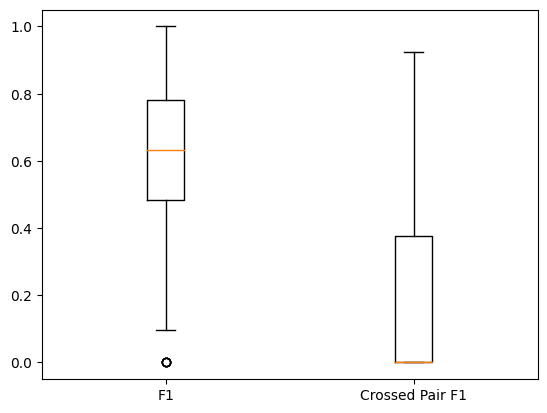

In [21]:
plt.boxplot([F1s,np.array(crossed_pair_F1s)[~np.isnan(crossed_pair_F1s)]])
plt.xticks([1, 2], ['F1', 'Crossed Pair F1'])
plt.savefig('/kaggle/working/F1_plot')


# Check how correlated eF1s are with true F1s

About 0.824 correlation, so pretty good! 

In [25]:
from scipy.stats import pearsonr
corr,p=pearsonr(F1s,[i['global_ef1'] for i in eF1s])

plt.title(f"Pearsonr: {corr:.2f}")
plt.scatter(F1s,[i['global_ef1'] for i in eF1s])
plt.xlabel('global F1')
plt.ylabel('global eF1')

ValueError: array must not contain infs or NaNs

Text(0, 0.5, 'Crossed Pair eF1')

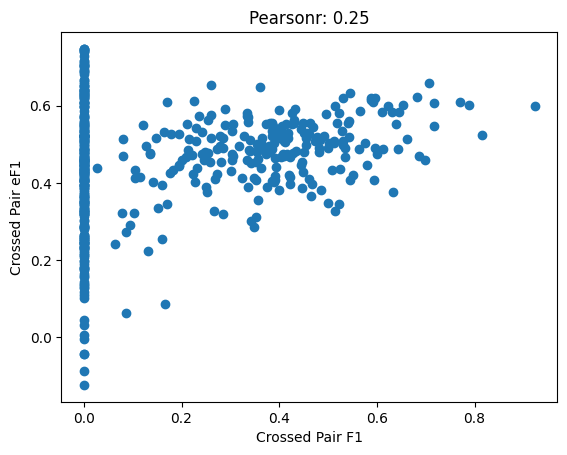

In [23]:
from scipy.stats import pearsonr
crossed_pair_F1s=np.array(crossed_pair_F1s)
crossed_pair_eF1s=np.array([i['crossed_pair_ef1'] for i in eF1s])

#mask nans only keep cases where both crossed_pair_F1s and crossed_pair_eF1s are defined
mask=np.isnan(crossed_pair_F1s)+np.isnan(np.array(crossed_pair_eF1s)) 
crossed_pair_F1s=np.array(crossed_pair_F1s)

corr,p=pearsonr(crossed_pair_F1s[~mask],crossed_pair_eF1s[~mask])

plt.title(f"Pearsonr: {corr:.2f}")
plt.scatter(crossed_pair_F1s,crossed_pair_eF1s)
plt.xlabel('Crossed Pair F1')
plt.ylabel('Crossed Pair eF1')